**This notebook prepares the external data from Unesco: GDP per capita, total population and life expectancy.**

All the Unesco files are downloaded from S3 bucket in csv format.

The overal reading results are prepared from the PIRLS 2021 database in order to calculate the correlation coefficient with the abovementioned UNESCO variables and prepare appropriate plots.

**Note**: the list of countries from PIRLS was adjusted to reflect the list of UNESCO countries e.g. 
- 'Belgium (Flemish)' and 'Belgium (French)' became 'Belgium'
- 'Iran, Islamic Rep. of' became 'Iran (Islamic Republic of)'

In [1]:
import sys 

sys.path.append('/home/ec2-user/SageMaker/GDSC')

In [ ]:
!pip install -r ./../requirements.txt

# download data

In [10]:
import boto3
import os
        
# download the data
files = ['UNESCO_total_population_2022_utf8.csv',
        'UNESCO_GDP_PER_CAPITA_CURRENT_US_2023_utf8.csv',
        'Unesco_life_expectancy_2022_utf8.csv']

# make directory locally to download data there
main_folder = 'external_data'
        
try:
    os.mkdir(f'{main_folder}')
except:
    print(f'{main_folder} already exists')

# download data
s3 = boto3.resource('s3')
for file in files:
    s3.meta.client.download_file('gdsc-bucket-058264313357', f'{main_folder}/{file}', f'./{main_folder}/{file}')

# read csv files

In [11]:
import pandas as pd

In [12]:
gdp_per_capita = pd.read_csv(f'{main_folder}/UNESCO_GDP_PER_CAPITA_CURRENT_US_2023_utf8.csv', sep = ';')
life_expectancy = pd.read_csv(f'{main_folder}/Unesco_life_expectancy_2022_utf8.csv', sep = ';')
total_population = pd.read_csv(f'{main_folder}/UNESCO_total_population_2022_utf8.csv', sep = ';')

# Let's take the data from the database

In [11]:
import psycopg2 # module for connecting to a PostgreSQL database
import pandas as pd  # module for data manipulation and analysis

import seaborn as sns # library for visualization of data
import matplotlib.pyplot as plt # library for visualization of data

pd.set_option('display.max_colwidth', None) # display all the contents of a column

# create helpful functions

def create_connection() -> psycopg2.extensions.connection:
    """
    Creates a connection to the PostgreSQL database. Uses the global variables DB_ENDPOINT, DB_PORT, DB_USER, DB_PASSWORD, DB_NAME.

    Returns:
        psycopg2.extensions.connection: A connection object to the PostgreSQL database.
    """
    return psycopg2.connect(
        host=DB_ENDPOINT,
        port=DB_PORT,
        user=DB_USER,
        password=DB_PASSWORD,
        database=DB_NAME
    )

def get_from_db(connection: psycopg2.extensions.connection, query: str) -> pd.DataFrame:
    """
    Executes the given SQL query on the provided database connection and returns the result as a pandas DataFrame.

    Parameters:
        connection (psycopg2.extensions.connection): The database connection object.
        query (str): The SQL query to execute.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the result of the query.

    Raises:
        psycopg2.Error: If there is an error executing the query.
    """
    try:
        with connection:
            with connection.cursor() as cursor:
                cursor.execute(query)
                result = cursor.fetchall()
                column_names = [desc[0] for desc in cursor.description]
    except psycopg2.Error as e:
        print(f"Error executing query: {e}")
        return pd.DataFrame()

    return pd.DataFrame(result, columns=column_names)

# Collect credentials

In [12]:
DB_PASSWORD=os.environ["DB_PASSWORD"]
DB_USER=os.environ["DB_USER"]
DB_ENDPOINT=os.environ["DB_ENDPOINT"]
DB_PORT=os.environ["DB_PORT"]
DB_NAME ='postgres'

# Connect to database 

In [13]:
connection = create_connection()

# Prepare the overal results from PIRLS database

In [14]:
query = '''
        SELECT 
            case
                when c.Name in  ('South Africa', 'South Africa (6)') then 'South Africa'
                when c.Name in ('Moscow City, Russian Federation', 'Russian Federation') then 'Russian Federation'
                when c.Name = 'Hong Kong SAR' then 'China, Hong Kong Special Administrative Region'
                when c.Name = 'Macao SAR' then 'China, Macao Special Administrative Region'
                when c.Name = 'United States' then 'United States of America'
                when c.Name in ('Northern Ireland', 'United Kingdom') then 'United Kingdom of Great Britain and Northern Ireland'
                when c.Name = 'Slovak Republic' then 'Slovakia'
                when c.Name = 'Czech Republic' then 'Czechia'
                when c.Name = 'Norway (5)' then 'Norway'
                when c.Name in ('Abu Dhabi, United Arab Emirates', 'Dubai, United Arab Emirates', 'United Arab Emirates') then 'United Arab Emirates'
                when c.Name in ('Belgium (Flemish)', 'Belgium (French)') then 'Belgium'
                when c.Name  = 'Turkiye' then 'Türkiye'
                when c.Name = 'Iran, Islamic Rep. of' then 'Iran (Islamic Republic of)'
                else c.Name end AS Country, 
                AVG(ssr.Score) AS Average_Reading_Score 
        FROM StudentScoreResults ssr JOIN Students s ON ssr.Student_ID = s.Student_ID JOIN Countries c ON s.Country_ID = c.Country_ID 
        WHERE ssr.Code = 'ASRREA_avg' 
        GROUP BY 1 
        ORDER BY Average_Reading_Score DESC
'''
AVG_score = get_from_db(connection, query)

display the results

In [15]:
pd.set_option('display.max_rows', None)
AVG_score

,country,average_reading_score
0,Russian Federation,586.136337
1,Singapore,583.006084
2,Ireland,578.487061
3,"China, Hong Kong Special Administrative Region",574.542602
4,United Kingdom of Great Britain and Northern Ireland,561.934054
5,Croatia,559.335414
6,United States of America,554.768494
7,"Quebec, Canada",553.742900
8,Lithuania,553.658919
9,Bulgaria,552.578354


# Join PIRLS results with external unesco data

In [16]:
join = pd.merge(AVG_score, gdp_per_capita, left_on='country', right_on = 'Country', how='left').drop('Country', axis = 1)
join = pd.merge(join, total_population, left_on='country', right_on = 'Country', how='left').drop('Country', axis = 1)
join = pd.merge(join, life_expectancy, left_on='country', right_on = 'Country', how='left').drop('Country', axis = 1)

rename columns

In [19]:
join.columns = ['country', 'average_reading_score','gdp_per_capita', 'population', 'life_expectancy']

In [22]:
import numpy as np

correct formats + prepare log of population so that its distribution fits better the purpose of correlation analysis and plotting.

In [23]:
join['log_population'] = np.log(join['population'])
join['life_expectancy'] = join['life_expectancy'].astype('float')

In [24]:
join.dtypes

country                   object
average_reading_score    float64
gdp_per_capita           float64
population               float64
life_expectancy          float64
log_population           float64
dtype: object

display joined data

In [25]:
join

,country,average_reading_score,gdp_per_capita,population,life_expectancy,log_population
0,Russian Federation,586.136337,13817.0,146980.0,73.0,11.898052
1,Singapore,583.006084,84734.0,5956.0,83.0,8.692154
2,Ireland,578.487061,103685.0,5006.0,83.0,8.518392
3,"China, Hong Kong Special Administrative Region",574.542602,50697.0,7489.0,84.0,8.921191
4,United Kingdom of Great Britain and Northern Ireland,561.934054,48867.0,67394.0,82.0,11.118311
5,Croatia,559.335414,21460.0,4041.0,78.0,8.304247
6,United States of America,554.768494,81695.0,337499.0,77.0,12.729318
7,"Quebec, Canada",553.742900,NaN,NaN,NaN,NaN
8,Lithuania,553.658919,27103.0,2769.0,76.0,7.926242
9,Bulgaria,552.578354,15798.0,6834.0,74.0,8.829665


# Prepare the plots and correlation coefficients

Plots are saved locally. They were uploaded manually to s3 for the purpose of being used in the answers.

# score vs gdp

In [26]:
import numpy as np

Correlation Coefficient of Average Overal Reading Score in PIRLS 2021 and GDP per capita (current US$) 2023: 0.5868783453611224


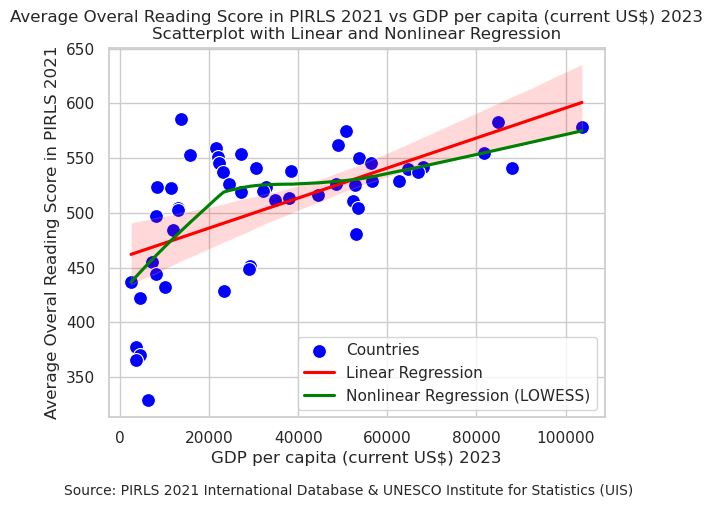

In [50]:
# Drop null values
df = join.copy()
kpi1 = 'average_reading_score'
kpi1_label = 'Average Overal Reading Score in PIRLS 2021'
kpi2 = 'gdp_per_capita'
kpi2_label = 'GDP per capita (current US$) 2023'

df = df[['country',kpi1, kpi2]]
df = df.dropna()

# Calculate correlation coefficient
correlation_coefficient = df[kpi1].corr(df[kpi2])
print(f"Correlation Coefficient of {kpi1_label} and {kpi2_label}: {correlation_coefficient}")

# Prepare scatterplot with linear and nonlinear regression
# Scatterplot
sns.scatterplot(x=kpi2, y=kpi1, data=df, s=100, color='blue', label='Countries')

# Linear regression line
sns.regplot(x=kpi2, y=kpi1, data=df, scatter=False, color='red', label='Linear Regression')

# Loess regression line
sns.regplot(x=kpi2, y=kpi1, data=df, scatter=False, lowess=True, line_kws={'color': 'green'}, label='Nonlinear Regression (LOWESS)')


# Add labels and title
plt.xlabel(kpi2_label)
plt.ylabel(kpi1_label)
plt.title(f'{kpi1_label} vs {kpi2_label}\nScatterplot with Linear and Nonlinear Regression')
plt.legend()

# Add footnote with source
plt.figtext(0.5, -0.05, "Source: PIRLS 2021 International Database & UNESCO Institute for Statistics (UIS)", wrap=True, horizontalalignment='center', fontsize=10)

plt.savefig('score_vs_gdp.png', dpi=300, bbox_inches='tight')

# Score vs Total Population

Correlation Coefficient of Average Overal Reading Score in PIRLS 2021 and Logarithm of Total population (thousands) 2022: -0.172222815854743


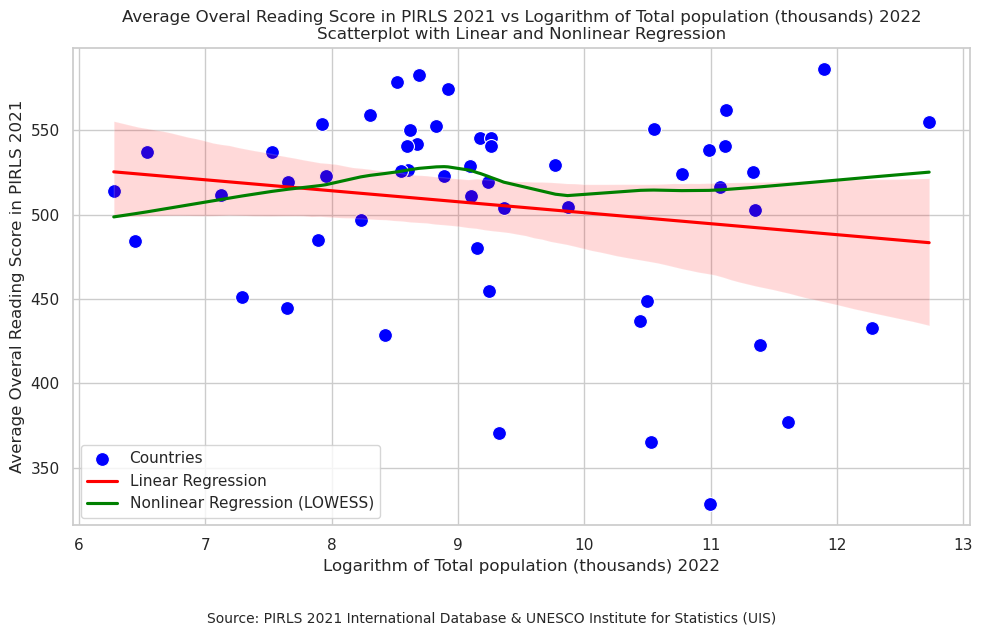

In [49]:
# Drop null values
df = join.copy()
kpi1 = 'average_reading_score'
kpi1_label = 'Average Overal Reading Score in PIRLS 2021'
kpi2 = 'log_population'
kpi2_label = 'Logarithm of Total population (thousands) 2022'

df = df[['country',kpi1, kpi2]]
df = df.dropna()

# Calculate correlation coefficient
correlation_coefficient = df[kpi1].corr(df[kpi2])
print(f"Correlation Coefficient of {kpi1_label} and {kpi2_label}: {correlation_coefficient}")

# Prepare scatterplot with linear and nonlinear regression
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Scatterplot
sns.scatterplot(x=kpi2, y=kpi1, data=df, s=100, color='blue', label='Countries')

# Linear regression line
sns.regplot(x=kpi2, y=kpi1, data=df, scatter=False, color='red', label='Linear Regression')

# Loess regression line
sns.regplot(x=kpi2, y=kpi1, data=df, scatter=False, lowess=True, line_kws={'color': 'green'}, label='Nonlinear Regression (LOWESS)')


# Add labels and title
plt.xlabel(kpi2_label)
plt.ylabel(kpi1_label)
plt.title(f'{kpi1_label} vs {kpi2_label}\nScatterplot with Linear and Nonlinear Regression')
plt.legend()

# Add footnote with source
plt.figtext(0.5, -0.05, "Source: PIRLS 2021 International Database & UNESCO Institute for Statistics (UIS)", wrap=True, horizontalalignment='center', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

# Score vs Life Expectancy

Correlation Coefficient of Average Overal Reading Score in PIRLS 2021 and Life expectancy at birth, total (years) 2022: 0.5363990072333491


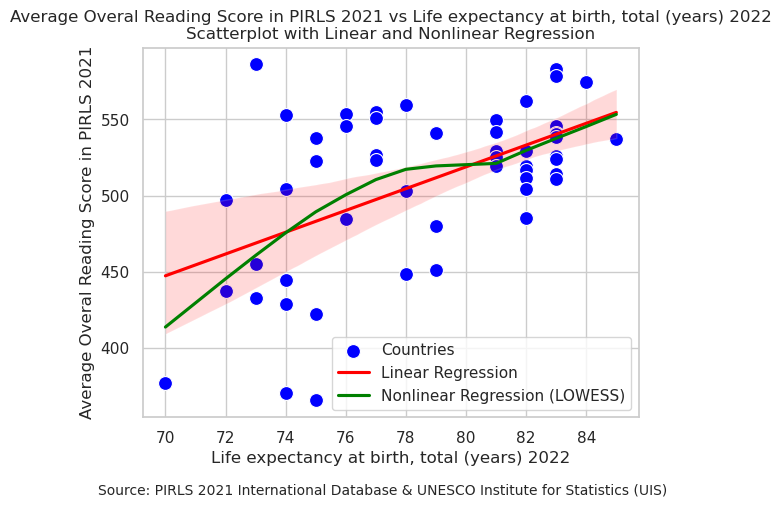

In [48]:
# Drop null values
df = join.copy()
kpi1 = 'average_reading_score'
kpi1_label = 'Average Overal Reading Score in PIRLS 2021'
kpi2 = 'life_expectancy'
kpi2_label = 'Life expectancy at birth, total (years) 2022'

df = df[['country',kpi1, kpi2]]
df = df.dropna()

#drop a clear outlier
df = df[df.country!='South Africa']

# Calculate correlation coefficient
correlation_coefficient = df[kpi1].corr(df[kpi2])
print(f"Correlation Coefficient of {kpi1_label} and {kpi2_label}: {correlation_coefficient}")

# Scatterplot
sns.scatterplot(x=kpi2, y=kpi1, data=df, s=100, color='blue', label='Countries')

# Linear regression line
sns.regplot(x=kpi2, y=kpi1, data=df, scatter=False, color='red', label='Linear Regression')

# Loess regression line
sns.regplot(x=kpi2, y=kpi1, data=df, scatter=False, lowess=True, line_kws={'color': 'green'}, label='Nonlinear Regression (LOWESS)')


# Add labels and title
plt.xlabel(kpi2_label)
plt.ylabel(kpi1_label)
plt.title(f'{kpi1_label} vs {kpi2_label}\nScatterplot with Linear and Nonlinear Regression')
plt.legend()

# Add footnote with source
plt.figtext(0.5, -0.05, "Source: PIRLS 2021 International Database & UNESCO Institute for Statistics (UIS)", wrap=True, horizontalalignment='center', fontsize=10)

plt.savefig('score_vs_life_expectancy.png', dpi=300, bbox_inches='tight')